# モジュールの準備

In [ ]:
!pip install -U ginza
!pip install dgl
!pip install captum
!pip install torch

# データロード

In [5]:
import pandas as pd

train_df = pd.read_json(
    'data/marc_ja-v1.0/train-v1.0.json', lines=True)
train_df = pd.concat([train_df[train_df['label'] == 'positive'].sample(
    500), train_df[train_df['label'] == 'negative'].sample(500)]).sample(frac=1)
test_df = pd.read_json(
    'data/marc_ja-v1.0/valid-v1.0.json', lines=True)
test_df = pd.concat([test_df[test_df['label'] == 'positive'].sample(
    100), test_df[test_df['label'] == 'negative'].sample(100)]).sample(frac=1)

display(train_df)
display(test_df)


,sentence,label,review_id
148562,このゲーム、すぐに倉庫が満杯になりイライラしてくる事が多くなってきます。それ理由は倉庫枠が5...,negative,R29QF5ML6K1CIA
83435,前作同様、最後まで聞く気になれません。すいません。バンドネームにつられて買ったようなものです...,negative,RJV58RXJ2YA9F
64238,感動しました！！１６曲目と１７曲目はタップの音も録音されていて自分がホールで見ているようです...,positive,RF61EGKH7PIXE
122095,使えません。広告の位置、ほんとひどい。すぐに消したほうがいいです。,negative,R2XG1XDWSJBQTA
55,Jazzのスタンダードとしてぜひじっくりと一度は聞いてみてほしい1枚です。初心者にも入りやす...,positive,R3R91I877K8PZZ
...,...,...,...
77761,以前からこの映画は好きでした。勢いあまってメモリアルボックスを買いましたが、正解だったと思い...,positive,R25MQZNVC9V1JY
132132,常時持ち運ぶにはややヘビーですが、逆にそのパワーは桁違いの安心感！皆でバッテリーをシェアする...,positive,RJELQSQAML43S
6661,非常に憤慨しております。注文時（2014/10/27）には吹き替えアリが届いてみればナシだな...,negative,R1MJRGODXGY788
70242,何回見てもチョー面白いです。引退しようが人は気持ちの持ちようでやればできる,positive,R3VNN4KGFUARX0


,sentence,label,review_id
315,マーティン・スコセッシがプロデューサーに加わっているのを見てショックを受けた。こんなアホ映画...,negative,R2GTEGGC4JD9OT
1284,全シーズンDVDが欲しいと思ってましたがシーズン毎に三枚×2のBOXを買う気にはなれず、まと...,negative,R3T3VM6BY9S1JL
1090,とにかく、ストーリー展開の早さ、テンポの良さで最初から最後まで一切、退屈しませんでした。途中...,positive,R2RGFB7QE7NOAH
1518,ＴＤＲでショーを見たあとに娘（１０才）がどうしても見たいと言っていたので、購入できて良かったです。,positive,R38TV5XHK6RUUU
5587,他のレビュアーがリマスターと記してますが、そんな事実はありません。以前にドナルド自身が監修し...,negative,R1MR5OVQTGLWTD
...,...,...,...
4540,映画館に3回観に行ったぐらい好きなゴジラだ。フィギュアと特典映像が楽しみで購入したがメイキン...,negative,R2WOWI3VRDPL7Y
4925,誰がって、ラッセル・クロウ。どうみても、太りすぎ。妻を脱獄させる＆カネの心配＆息子の養育など...,negative,R2JP08FEA5BDME
4092,イタリアを代表する2人の俳優が演じている名作だと思います。戦争の悲惨さ、男女の恋、そして別れ...,positive,R72V9XTYQQANW
893,米版と同じ仕様と思ったらメインディスクは以前リリースされていたものと同じ内容でした。監督のコ...,negative,RRE3REHLBHSO5


# 文をグラフ構造に変換する

In [6]:
import spacy

nlp = spacy.load('ja_ginza')


/Users/hideki/miniforge3/envs/dgl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentence: このゲーム、すぐに倉庫が満杯になりイライラしてくる事が多くなってきます。それ理由は倉庫枠が50あったとすると普通は50種類収納できると考えられると思いますが、違います。総数が50個までしか収納できないのです。分かりやすく例えると、ニンジン6個と小麦9個を倉庫に入れると枠を15使ってしまうのです。最初のうちは気にならないのですが、プレイし続けると倉庫のやりくりに頭を抱える事が多くなってやる気が削がれます。


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


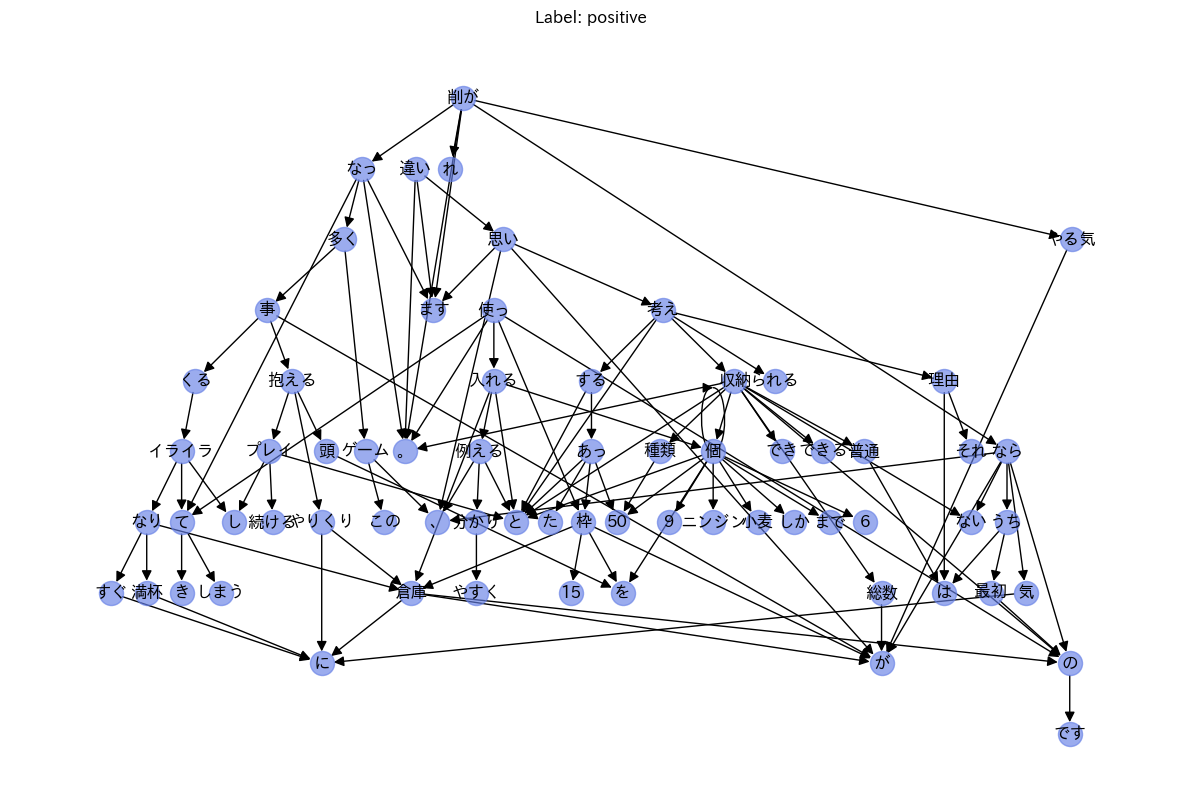

In [12]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np


def create_graph(doc: spacy.tokens.doc.Doc):
    edges = []
    vector_dict = {}
    node_id2names = {}
    for token in doc:
        vector_dict[token.text] = token.vector
        for child in token.children:
            edges.append((token.text, child.text))
            vector_dict[child.text] = child.vector
    graph = nx.DiGraph(edges)
    for i, (n, attr) in enumerate(graph.nodes.items()):
        graph.nodes[n]['feat'] = vector_dict[n]
        graph.nodes[n]['name_index'] = i
        node_id2names[i] = n
    g = dgl.from_networkx(graph, ['name_index', 'feat'])

    return g, node_id2names


def plot_tree(g, node_id2names, label, with_weight=False):
    relabels = {}
    base_size = 80
    base_color = [.4, .5, .9, .65]
    node_sizes = []
    for n, attr in g.nodes.items():
        relabels[n] = node_id2names[attr['name_index'].item()]
        if with_weight:
            scale = 1. + attr['weight'].detach().numpy()
            node_sizes.append(np.exp(scale**2) * base_size)
    g2 = nx.relabel_nodes(g, relabels)

    pos = nx.nx_agraph.graphviz_layout(g2, prog='dot')
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1)
    if with_weight:
        nx.draw(g2, pos, with_labels=True, node_size=node_sizes,
                node_color=base_color, arrowsize=15, font_family='IPAexGothic', ax=ax)
    else:
        nx.draw(g2, pos, with_labels=True, node_size=300,
                node_color=base_color, arrowsize=15, font_family='IPAexGothic', ax=ax)
    ax.set_title(
        f'Label: {"positive" if label == 1 else "negative"}')
    plt.show()


sentence = train_df.iloc[0]['sentence']
print(f'Sentence: {sentence}')

g, node_id2names = create_graph(
    nlp(sentence))
plot_tree(g.to_networkx(
    node_attrs=['name_index', 'feat']), node_id2names, label=1)


In [27]:
def create_features_and_labels(df):
    features = []
    labels = []
    node_id2names = []

    for index, row in df.iterrows():
        sentence = row['sentence']
        g, names = create_graph(nlp(sentence))

        features.append(g)
        label = 1 if row['label'] == 'positive' else 0
        label = np.array(label)
        labels.append(label)
        node_id2names.append(names)

    return features, labels, node_id2names


train_features, train_labels, train_node_id2names = create_features_and_labels(
    train_df)
test_features, test_labels, test_node_id2names = create_features_and_labels(
    test_df)


# モデルの準備

In [45]:
import torch.nn as nn
from dgl.nn import GraphConv, MaxPooling, AvgPooling


class GCN(nn.Module):
    def __init__(self,
                 in_feats,
                 num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, 32, allow_zero_in_degree=True)
        self.conv2 = GraphConv(32, 16, allow_zero_in_degree=True)
        self.pooling = AvgPooling()
        self.linear1 = nn.Linear(16, 256)
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, g, h):
        h = self.conv1(g, h)
        h = self.conv2(g, h)
        h = self.pooling(g, h)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        out = F.sigmoid(h)

        return out


model = GCN(train_features[0].ndata['feat'].shape[1], 1)
print(model)


GCN(
  (conv1): GraphConv(in=300, out=32, normalization=both, activation=None)
  (conv2): GraphConv(in=32, out=16, normalization=both, activation=None)
  (pooling): AvgPooling()
  (linear1): Linear(in_features=16, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)


# トレーニング

In [46]:
import torch
import torch.nn.functional as F
import numpy as np
from statistics import mean


def train(model, train_features, train_labels, report_period=500):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losss = []

    for step, (feature, label) in enumerate(zip(train_features, train_labels)):
        g = feature.add_self_loop()
        logits = model(g, feature.ndata['feat'])
        _label = torch.tensor(label).reshape(-1, 1).float()

        loss = F.binary_cross_entropy(logits, _label)
        losss.append(loss.clone().detach().numpy())
        # print(logits, _label, loss)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step > 0 and step % report_period == 0 or step == (len(train_features) - 1):
            print(f'step: {step + 1}, loss: {np.array(losss).mean()}')
            losss = []


for i in range(5):
    train(model, train_features, train_labels)


step: 501, loss: 0.668667197227478
step: 1000, loss: 0.5765957236289978
step: 501, loss: 0.5377157330513
step: 1000, loss: 0.5180661082267761
step: 501, loss: 0.5012080669403076
step: 1000, loss: 0.49455657601356506
step: 501, loss: 0.47661688923835754
step: 1000, loss: 0.47493264079093933
step: 501, loss: 0.45981916785240173
step: 1000, loss: 0.4573192596435547


# 評価

In [47]:
from sklearn.metrics import classification_report

preds = []
labels = []

for feature, label in zip(test_features, test_labels):
    g = feature.add_self_loop()
    pred = model(g, feature.ndata['feat'])

    preds.append(1 if pred > 0.5 else 0)
    labels.append(label)

confusion_matrix = np.zeros((2, 2))
for p, l in zip(preds, labels):
    confusion_matrix[p][l] += 1

cr = classification_report(labels, preds, output_dict=True)
pd.DataFrame(cr).T


,precision,recall,f1-score,support
0,0.769231,0.80,0.784314,100.00
1,0.791667,0.76,0.775510,100.00
accuracy,0.780000,0.78,0.780000,0.78
macro avg,0.780449,0.78,0.779912,200.00
weighted avg,0.780449,0.78,0.779912,200.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Sentence: 有名なスターは出ていませんが、とても面白い　レンタルしたが、やっぱり購入してみようと思う作品でした。


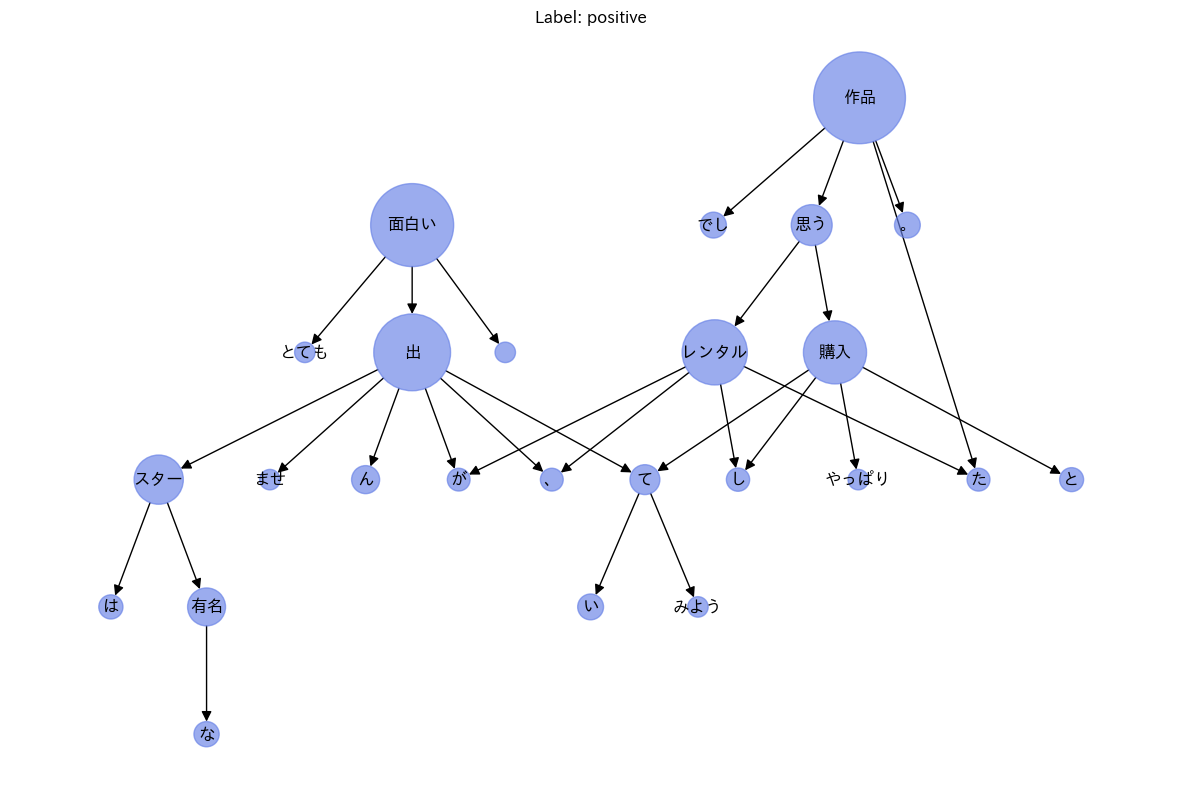

In [119]:
from captum.attr import IntegratedGradients
from functools import partial

# test_target_graph_index = 64 # positive sample
# test_target_graph_index = 77 # negative sample
test_target_graph_index = 64
g = test_features[test_target_graph_index].add_self_loop()
label = test_labels[test_target_graph_index]
sentence = test_df.iloc[test_target_graph_index]["sentence"]

h = g.ndata['feat'].clone().requires_grad_(True)
ig = IntegratedGradients(partial(model, g))

feat_attr = ig.attribute(
    h, target=0, internal_batch_size=g.num_nodes(), n_steps=10)

node_weights = feat_attr.abs().sum(dim=1)
node_weights = (node_weights - node_weights.min()) / node_weights.max()
g.ndata['weight'] = node_weights

print(f'Sentence: {sentence}')
plot_tree(g.remove_self_loop().to_networkx(
    node_attrs=['name_index', 'feat', 'weight']), test_node_id2names[test_target_graph_index], label=label, with_weight=True)